In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 한글 글꼴 설치(주의: 실행 후 런타임 다시 시작하기!)

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

## Library

In [3]:
import random
import pandas as pd
import numpy as np
import os
path = '/content/drive/MyDrive/02_코랩/01_데이콘/교원그룹'
os.chdir(path)

from PIL import Image
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

import seaborn as sns

import cv2 as cv

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 


In [4]:
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet18
from torchvision import transforms

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split



## 하이퍼파라미터

In [5]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':30,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'NUM_WORKERS':1, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

## Fixed Random Seed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

# Load Data Set

In [7]:
# Unzip File
#!unzip -qq '/content/drive/MyDrive/머신러닝 엔지니어링/데이콘/교원 그룹/data/교원그룹.zip'

## Load Train Set

In [8]:
df = pd.read_csv('/content/drive/MyDrive/02_코랩/01_데이콘/교원그룹/train.csv')

In [9]:
print(df.shape)
df.head()

(76888, 3)


,id,img_path,label
0,TRAIN_00000,./train/TRAIN_00000.png,빨간색
1,TRAIN_00001,./train/TRAIN_00001.png,머
2,TRAIN_00002,./train/TRAIN_00002.png,차차
3,TRAIN_00003,./train/TRAIN_00003.png,써
4,TRAIN_00004,./train/TRAIN_00004.png,놓치다


# EDA

## Length Label


In [10]:
df['len'] = df['len'] = df['label'].str.len()

In [11]:
df_len_count = pd.DataFrame(df['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']

display(df_len_count)

,len,len_count
0,2,28631
1,1,23703
2,3,13514
3,4,9988
4,5,1026
5,6,26


<Axes: xlabel='len', ylabel='len_count'>

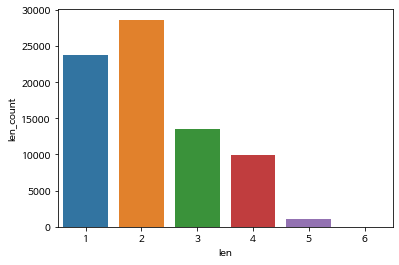

In [12]:
# label (글자)의 길이가 불균형
sns.barplot(data=df_len_count, x='len', y='len_count')

## Show Sample

In [ ]:
def sample_df_by_len(df, n_sample, n_len, use_frac=False):

  cond = (df['len']==n_len)
  df = df.loc[cond]

  if use_frac == True:
    df = df.sample(frac=n_sample)
  else:
    df = df.sample(n=n_sample)

  return df

In [ ]:
def show_sample_image(df, n_sample, n_len):
  df = sample_df_by_len(df, n_sample, n_len)
 
  for img, label in zip(df['img_path'], df['label']):
    print(img)
    plt.imshow(cv.imread(f'{img}'))
    #plt.title(label)
    plt.show()

In [ ]:
def show_sample_image_subclass(df, n_len):
  df = sample_df_by_len(df, 4, n_len)
  df.reset_index(drop=True, inplace = True)
  print(df)

  fig = plt.figure()
  fig.add_subplot(2, 2, 1)
  plt.imshow(cv.imread(str(df['img_path'][0])))
  fig.add_subplot(2, 2, 2)
  plt.imshow(cv.imread(str(df['img_path'][1])))
  fig.add_subplot(2, 2, 3)
  plt.imshow(cv.imread(str(df['img_path'][2])))
  fig.add_subplot(2, 2, 4)
  plt.imshow(cv.imread(str(df['img_path'][3])))

  plt.show()

### Len 1

            id                 img_path label  len
0  TRAIN_21167  ./train/TRAIN_21167.png     값    1
1  TRAIN_21589  ./train/TRAIN_21589.png     튱    1
2  TRAIN_08677  ./train/TRAIN_08677.png     넷    1
3  TRAIN_22633  ./train/TRAIN_22633.png     맺    1


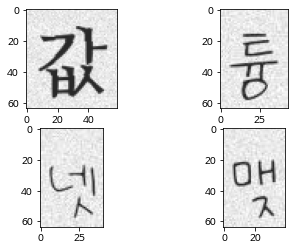

In [ ]:
# 이미지 사이즈가 일정하지 않음
# 배경에 노이즈가 존재
# 흑백 이미지
#show_sample_image(df=df, n_sample=3, n_len=1)
show_sample_image_subclass(df=df, n_len=1)

### Len 2

            id                 img_path label  len
0  TRAIN_21097  ./train/TRAIN_21097.png    조금    2
1  TRAIN_42721  ./train/TRAIN_42721.png    장인    2
2  TRAIN_26181  ./train/TRAIN_26181.png    연기    2
3  TRAIN_16576  ./train/TRAIN_16576.png    단독    2


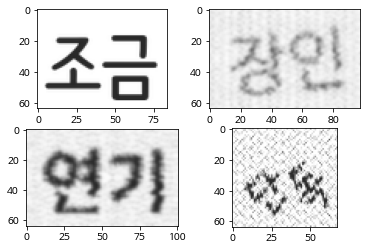

In [ ]:
# 기울러진 글씨가 존재
show_sample_image_subclass(df=df, n_len=2)

### Len 3

            id                 img_path label  len
0  TRAIN_08240  ./train/TRAIN_08240.png   그러다    3
1  TRAIN_58129  ./train/TRAIN_58129.png   부르다    3
2  TRAIN_21573  ./train/TRAIN_21573.png   더욱더    3
3  TRAIN_07137  ./train/TRAIN_07137.png   불고기    3


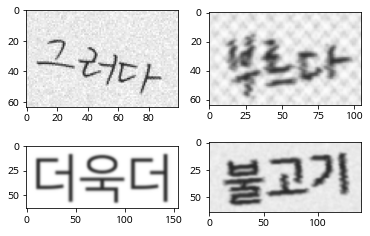

In [ ]:
show_sample_image_subclass(df=df, n_len=3)

### Len 4

            id                 img_path label  len
0  TRAIN_43803  ./train/TRAIN_43803.png  의미하다    4
1  TRAIN_11948  ./train/TRAIN_11948.png  예정되다    4
2  TRAIN_43655  ./train/TRAIN_43655.png  스튜디오    4
3  TRAIN_07874  ./train/TRAIN_07874.png  조정하다    4


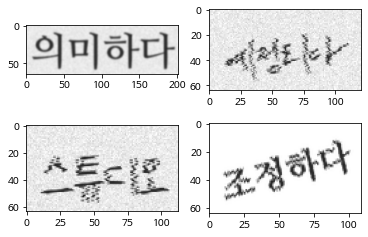

In [ ]:
show_sample_image_subclass(df=df, n_len=4)

### Len 5

            id                 img_path  label  len
0  TRAIN_26746  ./train/TRAIN_26746.png  고통스럽다    5
1  TRAIN_15845  ./train/TRAIN_15845.png  옛날이야기    5
2  TRAIN_16126  ./train/TRAIN_16126.png  따라다니다    5
3  TRAIN_31435  ./train/TRAIN_31435.png  뛰어오르다    5


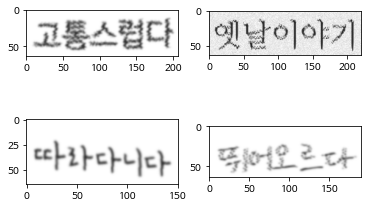

In [ ]:
show_sample_image_subclass(df=df, n_len=5)

### Len 6

            id                 img_path   label  len
0  TRAIN_19345  ./train/TRAIN_19345.png  두리번거리다    6
1  TRAIN_17838  ./train/TRAIN_17838.png  두리번거리다    6
2  TRAIN_16844  ./train/TRAIN_16844.png  불러일으키다    6
3  TRAIN_01235  ./train/TRAIN_01235.png  불러일으키다    6


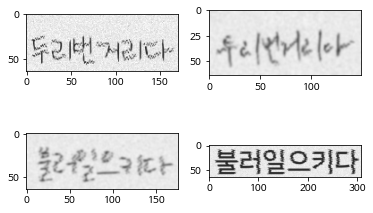

In [ ]:
show_sample_image_subclass(df=df, n_len=6)

## Count label by Len

In [ ]:
def show_count_label(df, n_len, n_show):

  df = sample_df_by_len(df=df, n_sample=1.0, n_len=n_len, use_frac=True)

  df = pd.DataFrame(df['label'].value_counts())
  df.reset_index(inplace=True)

  df.columns = ['label', 'count_label']
  df.sort_values(by='count_label', ascending=False, inplace=True)

  many_df = df.head(n_show)
  little_df = df.tail(n_show)

  fig, ax = plt.subplots(ncols=2, figsize=(13, 6))

  sns.barplot(data=many_df, x='count_label', y='label', ax=ax[0])
  ax[0].set_title(f'label 길이 {n_len}의 label 개수 상위 {n_show}')

  sns.barplot(data=little_df, x='count_label', y='label', ax=ax[1])
  ax[1].set_title(f'label 길이 {n_len}의 label 개수 하위 {n_show}')

  plt.show()

### Len 1

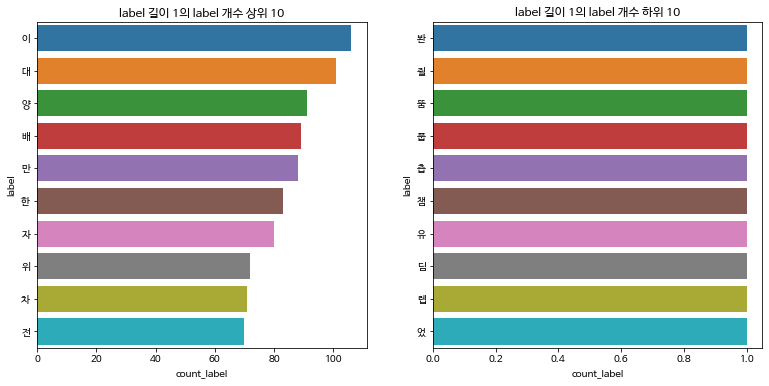

In [ ]:
# label 개수가 1개인 데이터 존재
show_count_label(df, 1, 10)

### Len 2

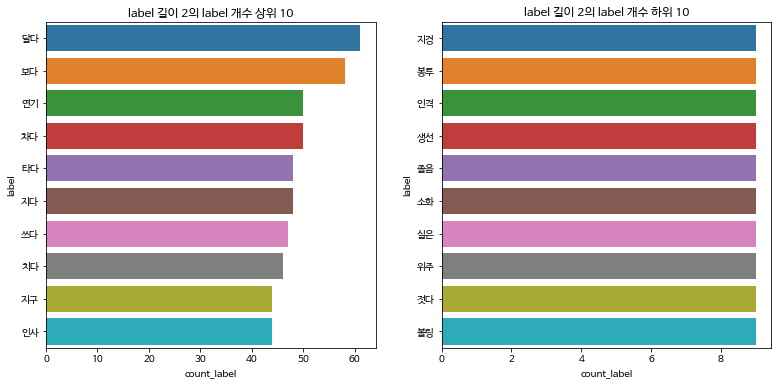

In [ ]:
show_count_label(df, 2, 10)

### Len 3

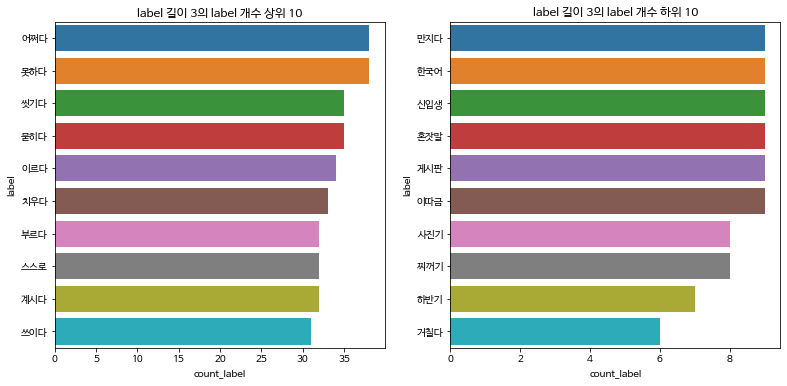

In [ ]:
show_count_label(df, 3, 10)

### Len 4

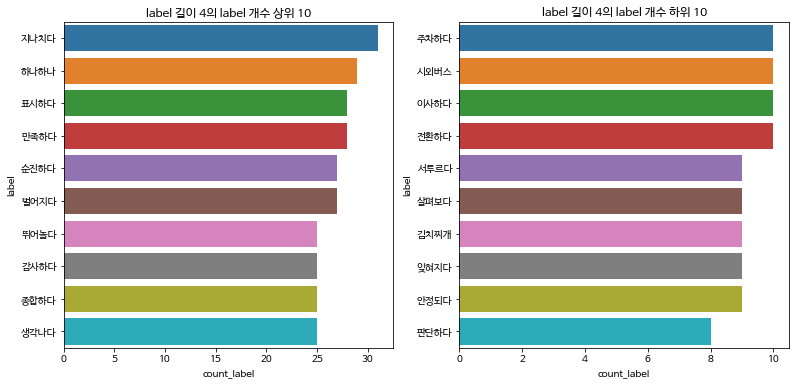

In [ ]:
show_count_label(df, 4, 10)

### Len 5

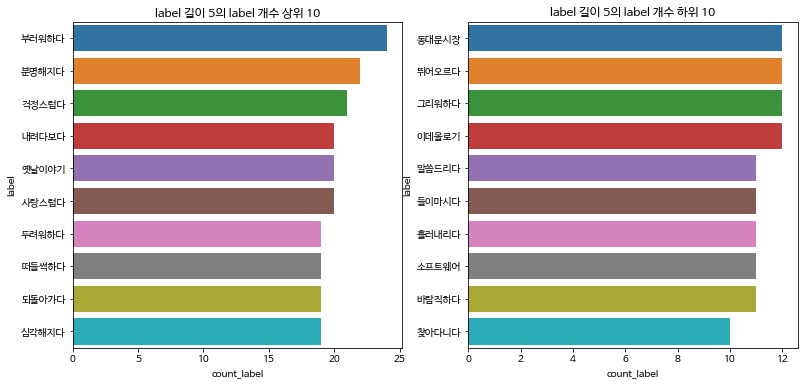

In [ ]:
show_count_label(df, 5, 10)

### Len 6

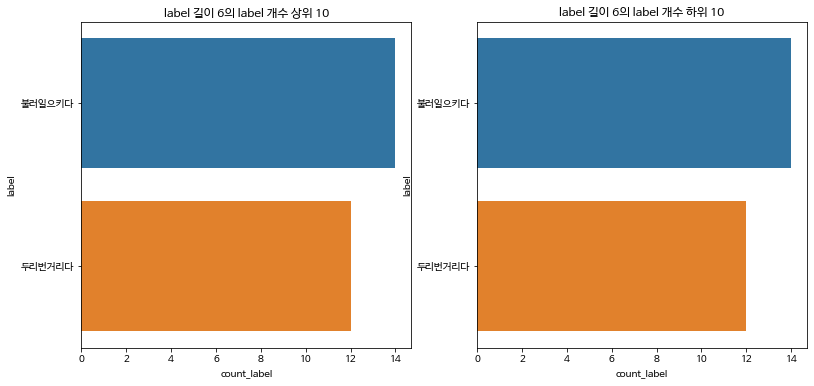

In [ ]:
# label이 '불러일으키다' & '두리번거리다' 밖에 없음
show_count_label(df, 6, 10)

## Check Image Size 

In [ ]:
X_size = []
Y_size = []

for path in tqdm(df['img_path']):

  image = Image.open(path)
  image_size = image.size

  X = image_size[0]
  Y = image_size[-1]

  X_size.append(X)
  Y_size.append(Y)

df['X'] = X_size
df['Y'] = Y_size

In [ ]:
# 세로 길이는 64로 통일
sns.scatterplot(data=df, x='X', y='Y')

In [ ]:
df['X'].max()

In [ ]:
# 가로 길이가 50 후반인 데이터가 많다
print('가장 긴 가로 길이 : {}'.format(df['X'].max()))
print('가장 짧은 가로 길이 : {}'.format(df['X'].min()))
print('평균 가로 길이 : {:.3f}'.format(df['X'].mean()))
sns.histplot(data=df, x='X')

In [ ]:
df_X_Size = pd.DataFrame(df['X'].value_counts())
df_X_Size.columns = ['X_Size_Count']
df_X_Size